#### Prepared for Gabor's Data Analysis

### Data Analysis for Business, Economics, and Policy
by Gabor Bekes and  Gabor Kezdi
 
Cambridge University Press 2021

**[gabors-data-analysis.com ](https://gabors-data-analysis.com/)**

 License: Free to share, modify and use for educational purposes. 
 Not to be used for commercial purposes.

### Chapter 08
**CH08B How is life expectancy related to the average income of a country?**

using the worldbank-lifeexpectancy dataset

version 1.0 2021-05-05 (modified for TA sessions 11.11.2023)

### Recap theory
**Linear regression** - **linear approximation**: $y^E = f(x) \sim \alpha + \beta x$

Potential **nonlinear shapes** matter if
- prediction
- uncovering more than the average pattern of association
- linear approximation is bad

Linear regression analysis can accomodate nonlinear patterns.

Most commonly used **transformations**:
- ***ln***
- ***piecewise linear splines***
- ***polynomials***
- ***ratios***

### Case study
How is life expectancy related to the average income of a country?

We want to identify contries where people live longer (or shorter) than what we would expect based on their income 

->analyze regression residuals -> good approximation of $y^E=f(x)$

We use World Bank data in 2017 and we will see:
- Log transformation
- GDP per capita vs Total GDP
- SPLINE
- Quadratic transformation
- Weighted and unweighted regressions

## Set up
- matplotlib.font_manager: module for finding, managing, and using fonts across platforms
- mizani.tranforms -> log_trans 
- mizani.formatters -> (percent_format for stacked bars with percentages, log_format for scatter with log scale)
- datetime: supplies classes for manipulating dates and times
- scipy.stats: statistical functions (module contains a large number of probability distributions, summary and frequency statistics, correlation functions and statistical tests, masked statistics, kernel density estimation, quasi-Monte Carlo functionality, and more)

*Mizani is Python package that provides the pieces necessary to create scales for a graphics system.

In [2]:
!pip install stargazer

  Obtaining dependency information for stargazer from https://files.pythonhosted.org/packages/05/ef/bf2eb43ff3047099f3c2f502040fcca384d3b035adf38cefcca96ae6cf92/stargazer-0.0.6-py3-none-any.whl.metadata


In [3]:
import os
import sys
import warnings

import numpy as np
import pandas as pd
import matplotlib.font_manager
from mizani.transforms import log_trans
from mizani.formatters import percent_format
from mizani.formatters import log_format
from plotnine import *
from datetime import datetime
from scipy.stats import norm
import statsmodels.formula.api as smf

from stargazer.stargazer import Stargazer

warnings.filterwarnings("ignore")


In [4]:
# Current script folder
current_path = os.getcwd()
dirname = current_path.split("TAsessions")[0]

# location folders
data_in = dirname + "TAsessions/da_data_repo/worldbank-lifeexpectancy/clean/"
data_out = dirname + "TAsessions/ch08-life-expectancy-income/"
output = dirname + "TAsessions/ch08-life-expectancy-income/output/"
func = dirname + "TAsessions/ch00-tech-prep/"
sys.path.append(func)


In [5]:
# Import the prewritten helper functions
from py_helper_functions import *


Read clean data

In [6]:
xc = pd.read_csv(data_in + "worldbank-lifeexpectancy.csv")

In [8]:
xc

,year,countryname,countrycode,lifeexp,population,gdppc
0,1990,Albania,ALB,71.836,3.286542,4.458248
1,1990,Algeria,DZA,66.725,25.758869,10.297842
2,1990,Angola,AGO,41.696,11.848386,4.761230
3,1990,Antigua and Barbuda,ATG,71.351,0.062528,17.472946
4,1990,Argentina,ARG,71.565,32.618651,11.372823
...,...,...,...,...,...,...
5024,2017,Vietnam,VNM,76.454,94.596642,6.233485
5025,2017,West Bank and Gaza,PSE,73.646,4.454805,4.651724
5026,2017,"Yemen, Rep.",YEM,65.157,27.834821,2.404422
5027,2017,Zambia,ZMB,62.255,16.853688,3.717667


select year 2017

In [9]:
xc = xc.loc[lambda x: x["year"] == 2017]

In [10]:
xc

,year,countryname,countrycode,lifeexp,population,gdppc
4847,2017,Afghanistan,AFG,64.047,36.296400,1.758466
4848,2017,Albania,ALB,78.495,2.873457,11.803284
4849,2017,Algeria,DZA,76.293,41.389198,13.876295
4850,2017,Angola,AGO,61.809,29.816748,6.044972
4851,2017,Antigua and Barbuda,ATG,76.519,0.095426,22.855748
...,...,...,...,...,...,...
5024,2017,Vietnam,VNM,76.454,94.596642,6.233485
5025,2017,West Bank and Gaza,PSE,73.646,4.454805,4.651724
5026,2017,"Yemen, Rep.",YEM,65.157,27.834821,2.404422
5027,2017,Zambia,ZMB,62.255,16.853688,3.717667


## LOG Transformations
Taking the natural log of a variable **approximates relative differences**: 

$\ln(x+\Delta x) - \ln(x) \approx \frac{\Delta x}{x}$

the difference between the $\ln$ of two values is approximately the relative difference between the two (for small differences, 30\% or smaller, either positive or negative)

For example: 

- if $x_2$ is 10\% larger than $x_1$, i.e. $x_2 =1.1 \times x_1$, then $\ln(x_2) -\ln(x_1) \approx 0.1 = 10\%$
- if $x_2$ is 10\% smaller than $x_1$, i.e. $x_2 =0.9 \times x_1$, then $\ln(x_2) -\ln(x_1) \approx -0.1 = -10\%$

-> log transformation allows for comparison in relative terms - percentages

**Note**: only possible for values >0

**WHEN?**: when comparison makes more sense in relative terms (percentage differences)

examples: prices, sales, GDP, population, employment, capital stock ...

In this case: look at distribution of GDP per capita and ln(GDP per capita)


In [11]:
xc["gdptot"] = xc["gdppc"] * xc["population"] #for subsequent exercise
xc["lngdppc"] = np.log(xc["gdppc"])
xc["lngdptot"] = np.log(xc["gdptot"])

In [14]:
xc.loc[:, ["lifeexp", "gdppc", "gdptot", "lngdppc", "lngdptot"]].describe()


,lifeexp,gdppc,gdptot,lngdppc,lngdptot
count,182.000000,182.000000,182.000000,182.000000,182.000000
mean,72.307650,19.227860,629.823545,2.371420,4.351424
std,7.648017,20.386738,2218.147072,1.182575,2.186134
min,52.214000,0.670777,0.231175,-0.399318,-1.464581
25%,66.829750,4.444143,22.788201,1.491582,3.126207
50%,73.914000,12.253987,74.441676,2.505850,4.309768
75%,77.402500,27.327675,352.111662,3.307899,5.863881
max,84.680488,113.262182,21148.059722,4.729705,9.959303


In [16]:
xc

,year,countryname,countrycode,lifeexp,population,gdppc,gdptot,lngdppc,lngdptot
4847,2017,Afghanistan,AFG,64.047,36.296400,1.758466,63.825972,0.564442,4.156160
4848,2017,Albania,ALB,78.495,2.873457,11.803284,33.916229,2.468378,3.523894
4849,2017,Algeria,DZA,76.293,41.389198,13.876295,574.328706,2.630182,6.353202
4850,2017,Angola,AGO,61.809,29.816748,6.044972,180.241408,1.799227,5.194297
4851,2017,Antigua and Barbuda,ATG,76.519,0.095426,22.855748,2.181033,3.129203,0.779798
...,...,...,...,...,...,...,...,...,...
5024,2017,Vietnam,VNM,76.454,94.596642,6.233485,589.666753,1.829936,6.379558
5025,2017,West Bank and Gaza,PSE,73.646,4.454805,4.651724,20.722522,1.537238,3.031221
5026,2017,"Yemen, Rep.",YEM,65.157,27.834821,2.404422,66.926666,0.877310,4.203597
5027,2017,Zambia,ZMB,62.255,16.853688,3.717667,62.656403,1.313096,4.137666


- 182 countries

- av life expectancy 72 years (range 52-85 -> substantial variation)

- total GDP from 0.2 billion to 20 trillion

*GDP per capita*
- average 19 000 US dollars
- median 12 000 (skewness)
- std 20 000 (spread)

*ln GDP per capita*
- average 2.4
- median 2.5 (symmetry)
- std 1.2

In [17]:
xc.sort_values(by=['lifeexp']).head(5)

,year,countryname,countrycode,lifeexp,population,gdppc,gdptot,lngdppc,lngdptot
4992,2017,Sierra Leone,SLE,52.214,7.488431,1.403791,10.512193,0.339176,2.352536
4879,2017,Central African Republic,CAF,52.890,4.596028,0.753825,3.464600,-0.282595,1.242597
4880,2017,Chad,TCD,53.208,15.016773,1.753772,26.335994,0.561769,3.270937
4969,2017,Nigeria,NGA,53.875,190.873311,5.351441,1021.447311,1.677366,6.928976
4888,2017,Cote d'Ivoire,CIV,54.102,24.437469,3.564596,87.109700,1.271051,4.467168


In [18]:
xc.sort_values(by=['lifeexp']).tail(5)

,year,countryname,countrycode,lifeexp,population,gdppc,gdptot,lngdppc,lngdptot
4998,2017,Spain,ESP,83.329268,46.593236,34.269116,1596.709020,3.534245,7.375700
5005,2017,Switzerland,CHE,83.602439,8.451840,57.997643,490.186803,4.060402,6.194787
4946,2017,"Macao SAR, China",MAC,83.991000,0.622585,105.448677,65.650765,4.658224,4.184349
4929,2017,Japan,JPN,84.099756,126.785797,38.907368,4932.901679,3.661184,8.503683
4918,2017,"Hong Kong SAR, China",HKG,84.680488,7.391700,56.087693,414.583404,4.026916,6.027274


#### Figure 8.3 The distribution of GDP per capita

(a) Histogram of GDP per capita

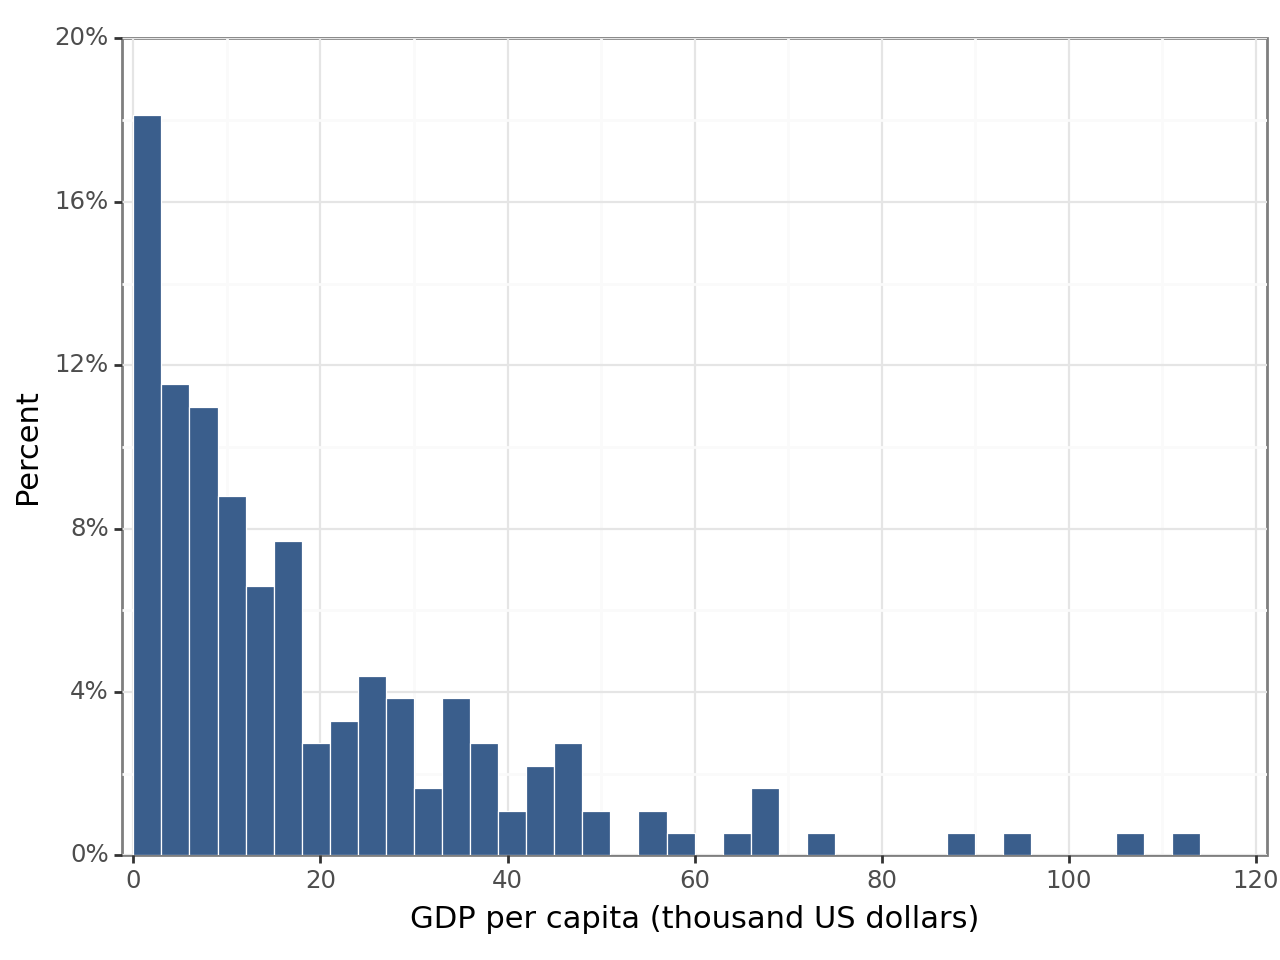

<Figure Size: (640 x 480)>

In [19]:
(
    ggplot(xc, aes(x="gdppc", y="stat(count)/sum(stat(count))"))
    + geom_histogram(
        binwidth=3,
        boundary=0,
        color="white",
        fill=color[0],
        size=0.25,
        alpha=0.8,
        show_legend=False,
        na_rm=True,
    )
    + labs(x="GDP per capita (thousand US dollars)", y="Percent")
    + expand_limits(x=0.01, y=0.01)
    + scale_x_continuous(expand=(0.01, 0.01), limits=(0, 120), breaks=seq(0, 120, 20))
    + scale_y_continuous(
        labels=percent_format(), #mizani
        breaks=seq(0, 0.20, 0.04),
        limits=(0, 0.2),
        expand=(0.0, 0.0),
    )
    + theme_bw()
)


Distribution skewed with a long right tail (take log?)

(b) Histogram of ln(GDP per capita)

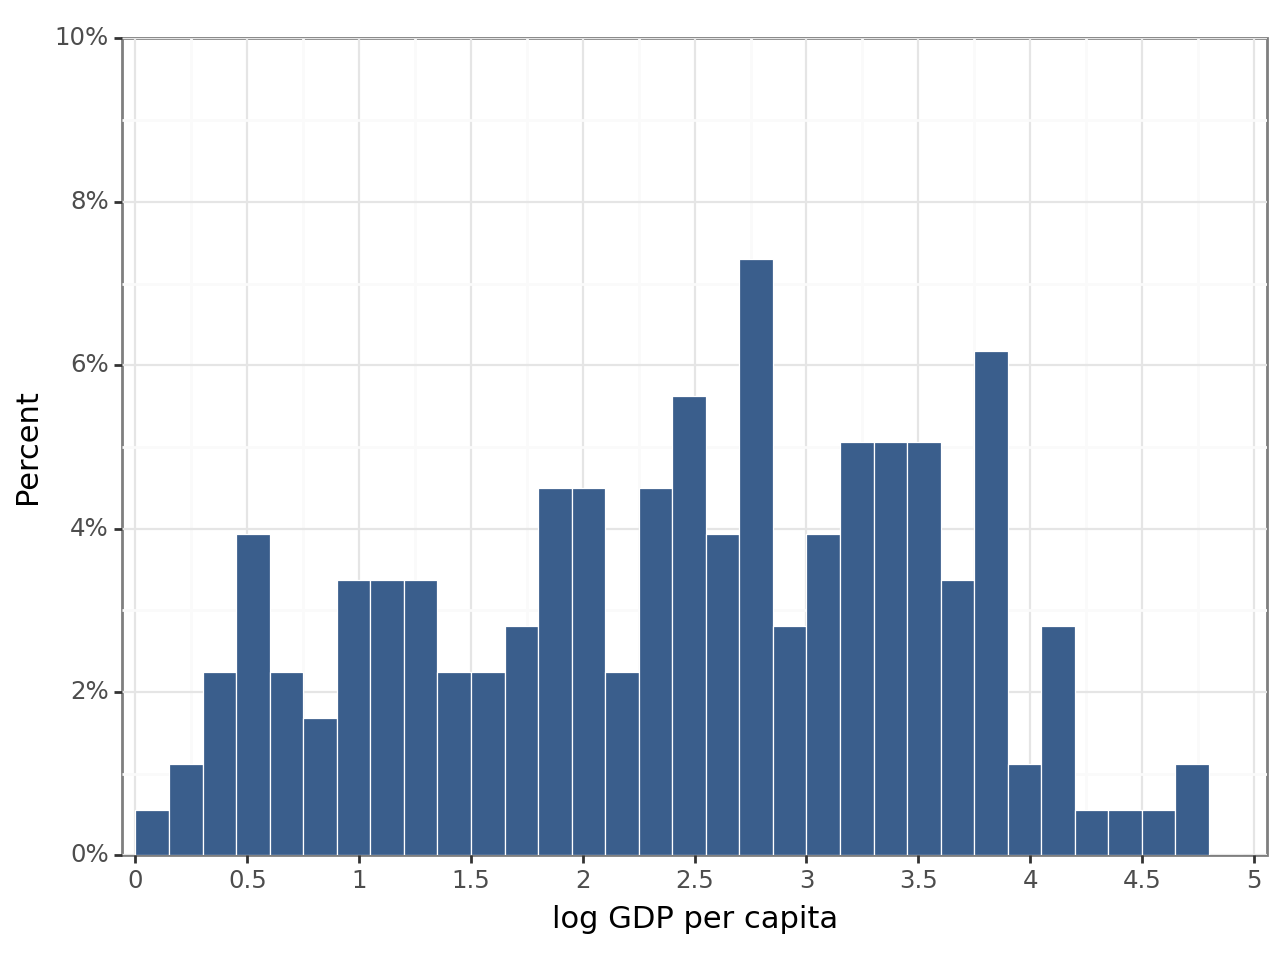

<Figure Size: (640 x 480)>

In [20]:
(
    ggplot(xc, aes(x="lngdppc", y="stat(count)/sum(stat(count))"))
    + geom_histogram(
        binwidth=0.15,
        boundary=0,
        color="white",
        fill=color[0],
        size=0.25,
        alpha=0.8,
        show_legend=False,
        na_rm=True,
    )
    + labs(x="log GDP per capita", y="Percent")
    + expand_limits(x=0.01, y=0.01)
    + scale_x_continuous(expand=(0.01, 0.01), limits=(0, 5), breaks=seq(0, 5, 0.5))
    + scale_y_continuous(
        expand=(0.0, 0.0),
        limits=(0, 0.1),
        breaks=seq(0, 0.1, 0.02),
        labels=percent_format(), #mizani
    )
    + theme_bw()
)


The distribution is close to symmetric

In [21]:
#xc.sort_values(by=['gdppc']).head(5)

In [22]:
#xc.sort_values(by=['gdppc']).tail(5)

 ### LEVEL-LEVEL REGRESSION

In [23]:
reg3 = smf.ols(formula="lifeexp ~ gdppc", data=xc).fit()
reg3.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                lifeexp   R-squared:                       0.442
Model:                            OLS   Adj. R-squared:                  0.439
Method:                 Least Squares   F-statistic:                     142.4
Date:                Mon, 13 Nov 2023   Prob (F-statistic):           1.47e-24
Time:                        15:53:50   Log-Likelihood:                -574.97
No. Observations:                 182   AIC:                             1154.
Df Residuals:                     180   BIC:                             1160.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     67.5137      0.585    115.478      0.000      66.360      68.667
gdppc          0.2493      0.021     11.933      0.000       0.208       0.291
==============================================================================
Omnibus:                       22.094   Durbin-Watson:                   2.006
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               26.566
Skew:                          -0.925   Prob(JB):                     1.70e-06
Kurtosis:                       3.285   Cond. No.                         38.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### Figure 8.4 Life expectancy and GDP per capita

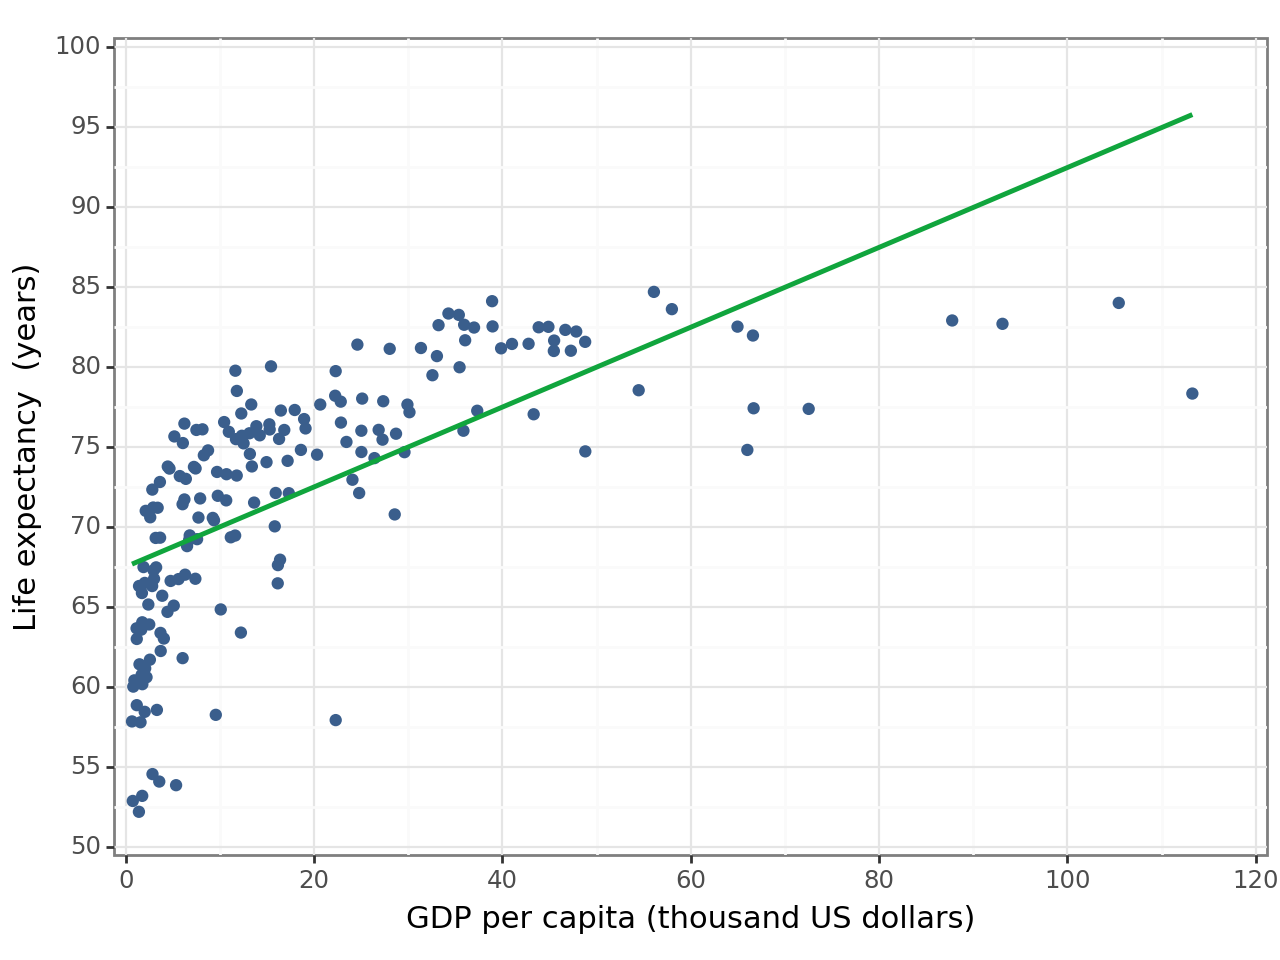

<Figure Size: (640 x 480)>

In [24]:
(
    ggplot(xc, aes(x="gdppc", y="lifeexp"))
    + geom_point(color=color[0])
    + geom_smooth(color=color[1], method="lm", se=False)
    + coord_cartesian(xlim=(0, 120), ylim=(50, 100))
    + expand_limits(x=0.01, y=0.01)
    + scale_x_continuous(
        expand=(0.01, 0.01), limits=(0, 120), breaks=seq(0, 120, by=20)
    )
    + scale_y_continuous(expand=(0.01, 0.01), breaks=seq(50, 100, by=5))
    + labs(x="GDP per capita (thousand US dollars)", y="Life expectancy  (years)")
    + theme_bw()
)


Level-level regression:
- positve slope
- visible nonlinearities from scatterplot (slope a lot steeper at lower levels of GDP per capita)
-> the regression does not capture it
- skewed x 
-> not good approximation of the average of that nonlinear pattern
- $R^2=0.442$


### LOG GDP PER CAPITA

##### Interpreting parameters

- log-log regression: $(\ln y)^E =\alpha +\beta \ln x$ -> $y$ is $\beta$\% higher, on average, for observations having 1\% higher $x$

- log-level regression: $(\ln y)^E =\alpha +\beta x$ -> $y$ is $\beta\times 100$\% higher, on average, for observations having 1 unit higher $x$

- level-log regression: $(y)^E =\alpha +\beta \ln x$ -> $y$ is $\frac{\beta}{100}$ units higher, on average, for observations having 1\% higher $x$

In [25]:
reg4 = smf.ols(formula="lifeexp ~ lngdppc", data=xc).fit()
reg4.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                lifeexp   R-squared:                       0.680
Model:                            OLS   Adj. R-squared:                  0.678
Method:                 Least Squares   F-statistic:                     382.8
Date:                Mon, 13 Nov 2023   Prob (F-statistic):           2.00e-46
Time:                        15:53:53   Log-Likelihood:                -524.28
No. Observations:                 182   AIC:                             1053.
Df Residuals:                     180   BIC:                             1059.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     59.6593      0.722     82.628      0.000      58.235      61.084
lngdppc        5.3336      0.273     19.565      0.000       4.796       5.872
==============================================================================
Omnibus:                       40.029   Durbin-Watson:                   2.238
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               68.168
Skew:                          -1.116   Prob(JB):                     1.58e-15
Kurtosis:                       5.002   Cond. No.                         6.65
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

**Interpretation**: 
- slope 5.3: countries with 1\% higher GDP per capita have life expectancy higher by 0.053 years, on average

(std log GDP per capita is more than 1 -> cross country differences not 1\% but in the order of hundred percents, but remember that log transformation performs badly with great differences)

-> interpret with 10\% changes: countries with 10\% higher GDP per capita have life expectancy higher by 0.53 years, on average


#### Figure 8.5 Life expectancy and GDP per capita

(a) Life expectancy and ln(GDP per capita)

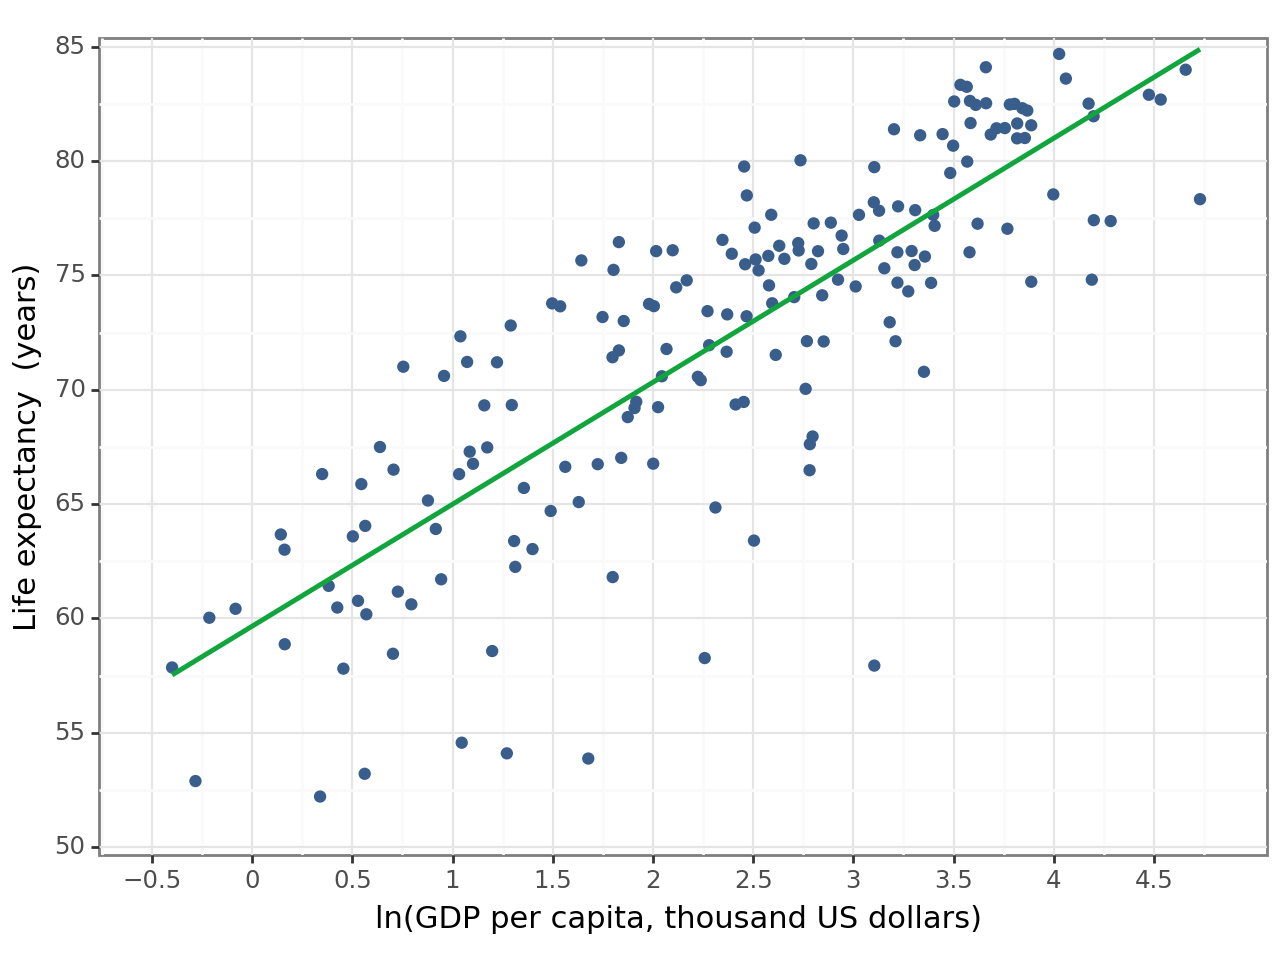

<Figure Size: (640 x 480)>

In [26]:
(
    ggplot(xc, aes(x="lngdppc", y="lifeexp"))
    + geom_point(color=color[0])
    + geom_smooth(color=color[1], method="lm", se=False)
    + coord_cartesian(xlim=(-0.5, 4.8), ylim=(50, 85))
    + scale_x_continuous(breaks=seq(-0.5, 4.5, by=0.5))
    + scale_y_continuous(expand=(0.01, 0.01), breaks=seq(50, 85, by=5))
    + labs(x="ln(GDP per capita, thousand US dollars) ", y="Life expectancy  (years)")
    + theme_bw()
)


Level-log regression:
- scatterplot suggests linear pattern
- good approximation of conditional expectation (for most range of log GDP per capita)

- higher $R^2$

-> prefer level-log

In [27]:
stargazer = Stargazer([reg3, reg4])
stargazer.covariate_order(["gdppc", "lngdppc", "Intercept"])
stargazer.custom_columns(["lifeexp", "lifeexp"], [1, 1])
stargazer.rename_covariates(
    {
        "Intercept": "Constant",
        "gdppc": "GDP per capita, level",
        "lngdppc": "ln(GDP per capita)",
    }
)
stargazer

(b) Life expectancy and ln(GDP per capita),
(labels are thousand dollars)

-> for better interpretation: same figure as before but with natural units instead of log values on x-axis

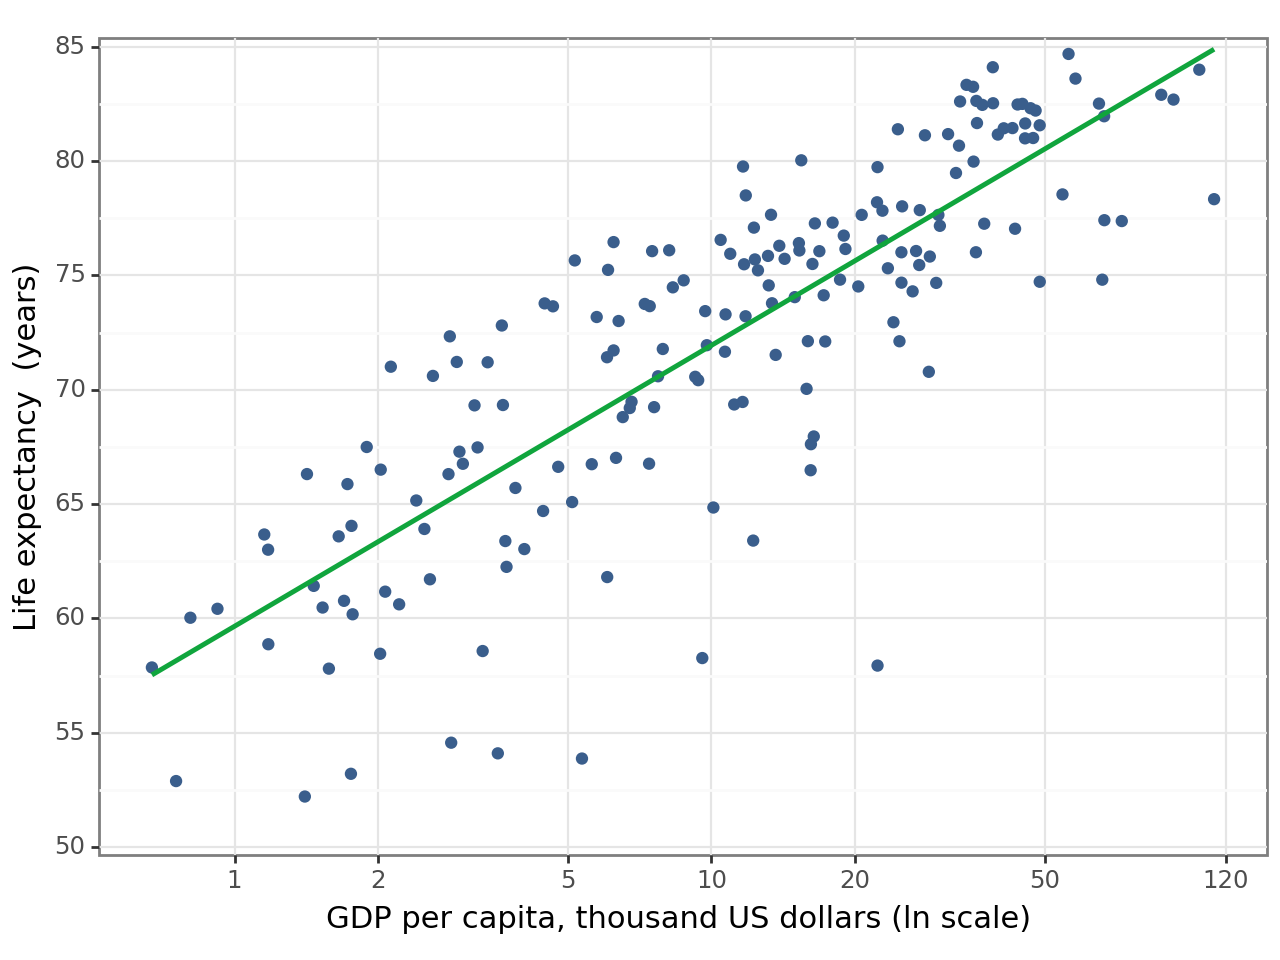

<Figure Size: (640 x 480)>

In [28]:
(
    # plot the level GDP per capita
    ggplot(xc, aes(x="gdppc", y="lifeexp"))
    + geom_point(color=color[0])
    + geom_smooth(color=color[1], method="lm", se=False)
    + coord_cartesian(ylim=(50, 85))
    # with log scale
    #do this with log_trans() and log_format()
    + scale_x_continuous(
        trans=log_trans(), #mizani
        breaks=(1, 2, 5, 10, 20, 50, 120), #breaks=seq(0, 120, by=20),
        labels=log_format() #mizani
    )
    + scale_y_continuous(expand=(0.01, 0.01), breaks=seq(50, 85, by=5))
    + labs(
        x="GDP per capita, thousand US dollars (ln scale) ",
        y="Life expectancy  (years)",
    )
    + theme_bw()
)

#### Indentify countries with especially long or short lives for their average income
-> use level-log model

In [29]:
xc["reg4_predprice"] = reg4.predict() #predicted values
xc["reg4_e"] = reg4.resid #residuals

In [30]:
xc["reg4_res"] = ["long_lives" if reg4_e >= 0 else "short_lives" for reg4_e in xc["reg4_e"]]

In [31]:
xc.loc[xc["reg4_e"].sort_values().tail().index, "reg4_res"] = "top5"
xc.loc[xc["reg4_e"].sort_values().head().index, "reg4_res"] = "bottom5" 
#tail - longest lives (top 5)
#head - shortest lives (bottom 5)

In [32]:
xc.loc[xc["reg4_e"].sort_values().head().index]

,year,countryname,countrycode,lifeexp,population,gdppc,gdptot,lngdppc,lngdptot,reg4_predprice,reg4_e,reg4_res
4898,2017,Equatorial Guinea,GNQ,57.939,1.262001,22.298942,28.141287,3.104539,3.337238,76.217849,-18.278849,bottom5
4969,2017,Nigeria,NGA,53.875,190.873311,5.351441,1021.447311,1.677366,6.928976,68.605809,-14.730809,bottom5
4900,2017,Eswatini,SWZ,58.268,1.124753,9.567586,10.761171,2.258381,2.375944,71.704738,-13.436738,bottom5
4888,2017,Cote d'Ivoire,CIV,54.102,24.437469,3.564596,87.109700,1.271051,4.467168,66.438667,-12.336667,bottom5
4941,2017,Lesotho,LSO,54.568,2.091412,2.845890,5.951927,1.045876,1.783715,65.237662,-10.669662,bottom5


*Equatorial Guinea* has average life expectancy 18 years shorter than what we would given its GDP per capita

In [33]:
xc.loc[xc["reg4_e"].sort_values().tail().index]

,year,countryname,countrycode,lifeexp,population,gdppc,gdptot,lngdppc,lngdptot,reg4_predprice,reg4_e,reg4_res
4940,2017,Lebanon,LBN,79.758,6.811873,11.647018,79.338008,2.455050,4.373717,72.753703,7.004297,top5
5024,2017,Vietnam,VNM,76.454,94.596642,6.233485,589.666753,1.829936,6.379558,69.419562,7.034438,top5
5023,2017,Vanuatu,VUT,72.334,0.285510,2.827080,0.807160,1.039245,-0.214234,65.202294,7.131706,top5
4967,2017,Nicaragua,NIC,75.653,6.384855,5.169298,33.005217,1.642737,3.496666,68.421110,7.231890,top5
4996,2017,Solomon Islands,SLB,71.006,0.636038,2.126353,1.352441,0.754408,0.301911,63.683078,7.322922,top5


In [34]:
xc.loc[lambda x: x["countrycode"] == "USA"] 

,year,countryname,countrycode,lifeexp,population,gdppc,gdptot,lngdppc,lngdptot,reg4_predprice,reg4_e,reg4_res
5020,2017,United States,USA,78.539024,325.147121,54.470797,17711.022716,3.997665,9.781942,80.981466,-2.442442,short_lives


in the *USA* life expectancy is two years shorter than expected 

### TOTAL GDP
Why is a bad idea to use total GDP? 

It reflects 2 variations:
- population size
- GDP per capita

We are interested in the association of life expectancy with the average income (not population size)!

Level-level regression

In [35]:
reg1 = smf.ols(formula="lifeexp ~ gdptot", data=xc) #corrected error (it was same as reg3)
reg1.fit().summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                lifeexp   R-squared:                       0.024
Model:                            OLS   Adj. R-squared:                  0.018
Method:                 Least Squares   F-statistic:                     4.410
Date:                Mon, 13 Nov 2023   Prob (F-statistic):             0.0371
Time:                        15:53:56   Log-Likelihood:                -625.81
No. Observations:                 182   AIC:                             1256.
Df Residuals:                     180   BIC:                             1262.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     71.9718      0.584    123.247      0.000      70.820      73.124
gdptot         0.0005      0.000      2.100      0.037    3.22e-05       0.001
==============================================================================
Omnibus:                       10.863   Durbin-Watson:                   1.807
Prob(Omnibus):                  0.004   Jarque-Bera (JB):               11.451
Skew:                          -0.588   Prob(JB):                      0.00326
Kurtosis:                       2.640   Cond. No.                     2.39e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.39e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

#### Figure 8.6 Life expectancy and total GDP

(a) Life expectancy and total GDP

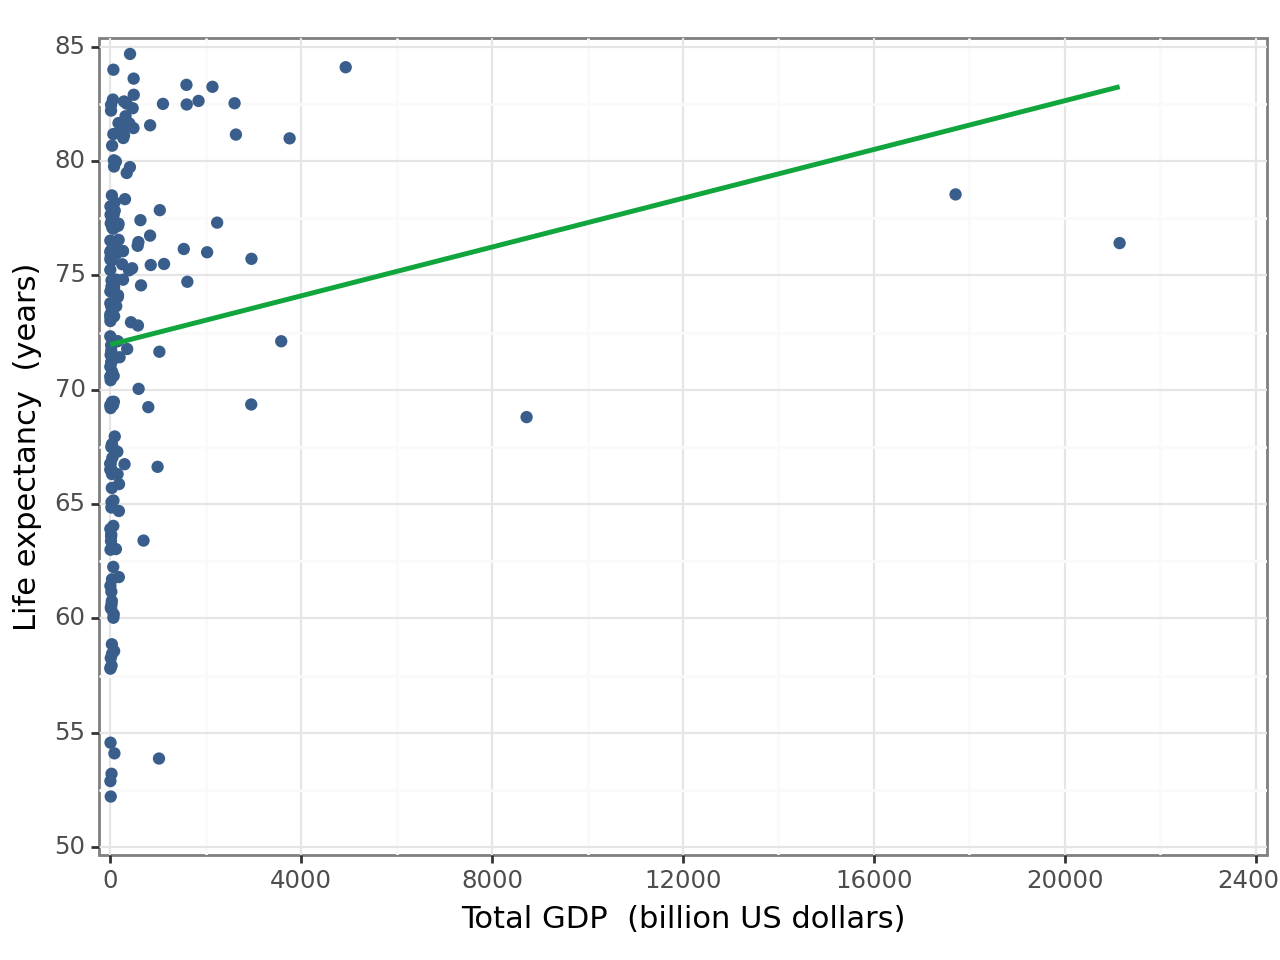

<Figure Size: (640 x 480)>

In [36]:
(
    ggplot(xc, aes(x="gdptot", y="lifeexp"))
    + geom_point(color=color[0])
    + geom_smooth(color=color[1], method="lm", se=False)
    + coord_cartesian(xlim=(0, 24000), ylim=(50, 85))
    + expand_limits(x=0.01, y=0.01)
    + scale_x_continuous(
        expand=(0.01, 0.01), limits=(0, 24000), breaks=seq(0, 24000, by=4000)
    )
    + scale_y_continuous(expand=(0.01, 0.01), limits=(50, 85), breaks=seq(50, 85, by=5))
    + labs(x="Total GDP  (billion US dollars)", y="Life expectancy  (years)")
    + theme_bw()
)


Very bad!

In [37]:
reg2 = smf.ols(formula="lifeexp ~ lngdptot", data=xc)
reg2.fit().summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                lifeexp   R-squared:                       0.140
Model:                            OLS   Adj. R-squared:                  0.135
Method:                 Least Squares   F-statistic:                     29.30
Date:                Mon, 13 Nov 2023   Prob (F-statistic):           1.96e-07
Time:                        15:53:57   Log-Likelihood:                -614.29
No. Observations:                 182   AIC:                             1233.
Df Residuals:                     180   BIC:                             1239.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     66.6120      1.177     56.598      0.000      64.290      68.934
lngdptot       1.3089      0.242      5.413      0.000       0.832       1.786
==============================================================================
Omnibus:                       12.032   Durbin-Watson:                   1.929
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               13.170
Skew:                          -0.645   Prob(JB):                      0.00138
Kurtosis:                       2.732   Cond. No.                         11.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

(b) Life expectancy and ln total GDP

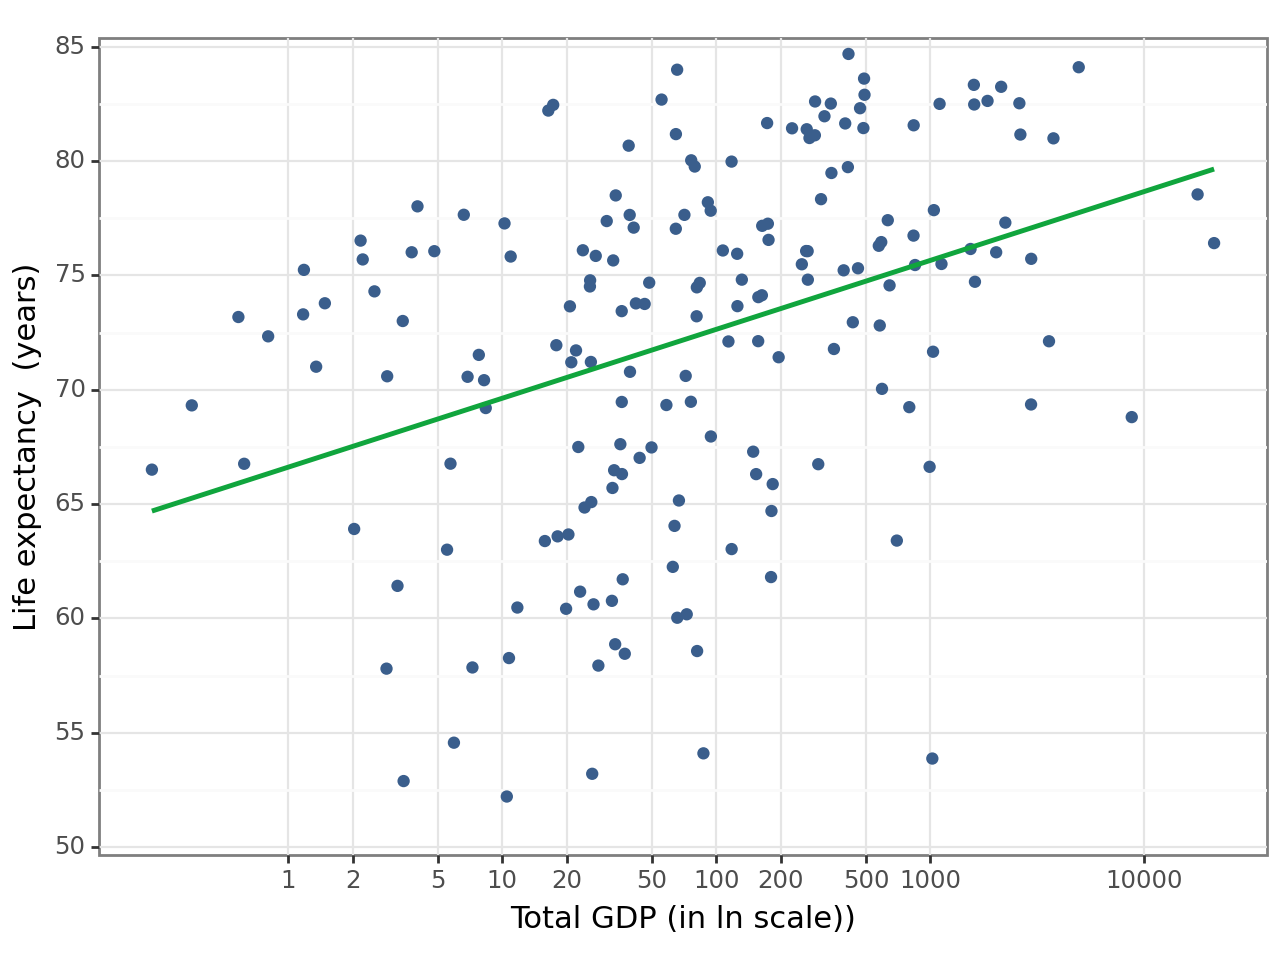

<Figure Size: (640 x 480)>

In [38]:
(
    ggplot(xc, aes(x="gdptot", y="lifeexp"))
    + geom_point(color=color[0])
    + geom_smooth(color=color[1], method="lm", se=False)
    + coord_cartesian(ylim=(50, 85))
    + scale_x_continuous(
        trans=log_trans(),
        breaks=(1, 2, 5, 10, 20, 50, 100, 200, 500, 1000, 10000),
        labels=log_format(),
    )
    + scale_y_continuous(expand=(0.01, 0.01), breaks=(50, 55, 60, 65, 70, 75, 80, 85))
    + labs(x="Total GDP (in ln scale))", y="Life expectancy  (years)")
    + theme_bw()
)

Does not look as bad and the $R^2$ not as low. But regression is misleading too (2 variations)

### SPLINE
Spline regression -> connected line segments (each line for a specific interval of x)

$y^E = \alpha_1 + \beta_1x[if x<k_1]+(\alpha_2+\beta_2x)[if k_1 \le x \le k_2]+\dots +(\alpha_m+\beta_mx)[if x \ge k_{m-1}]$

- $\alpha$ = average y when x is 0
- $\beta_1$ for x values less than $k_1$, y is $\beta_1$ units higher on average for observations with one unit higher x
- ...

(m number of segments)



### GDP PER CAPITA PIECEWISE LINEAR SPLINE
The scatterplot above reveals that the association between life expectancy and log GDP per capita may be flatter for countries with highest GDP per capita. 

Look back at fig 8.4 -> life expect is below the linear regression line for the highest-GDP countries (GDP per capita over 50 000 dollars -> 4.9 in ln $[\ln(50)]$)
-> use this cutoff


In [39]:
#xc.sort_values(by=['gdppc']).tail(10)

In [40]:
cutoff = 50
cutoff_ln = np.log(cutoff)

In [41]:
reg5 = smf.ols(formula="lifeexp ~ lspline(lngdppc,cutoff_ln)", data=xc).fit()
reg5.summary()
#in lspline first the explanatory variable and then the cutoff


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                lifeexp   R-squared:                       0.686
Model:                            OLS   Adj. R-squared:                  0.683
Method:                 Least Squares   F-statistic:                     195.9
Date:                Mon, 13 Nov 2023   Prob (F-statistic):           8.31e-46
Time:                        15:53:58   Log-Likelihood:                -522.47
No. Observations:                 182   AIC:                             1051.
Df Residuals:                     179   BIC:                             1061.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==================================================================================================
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept                         59.2872      0.743     79.767      0.000      57.821      60.754
lspline(lngdppc, cutoff_ln)[0]     5.5526      0.294     18.868      0.000       4.972       6.133
lspline(lngdppc, cutoff_ln)[1]    -0.2941      2.981     -0.099      0.922      -6.177       5.588
==============================================================================
Omnibus:                       43.162   Durbin-Watson:                   2.242
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               79.564
Skew:                          -1.154   Prob(JB):                     5.28e-18
Kurtosis:                       5.273   Cond. No.                         25.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Slope of first segments = 5.55 (life expect is higher, on average, by approx 0.55 yers in countries with 10\% higher GDP per capita)

Slope of the second = -0.3 

$R^2$ = 0.69 (before 0.68, very small improvement)



In [42]:
xc["e3"] = reg5.resid
xc["sppred"] = reg5.predict()


### Figure 8.7 Life expectancy and GDP per capita: scatterplot and nonlinear regression

(a) Piecewise linear spline

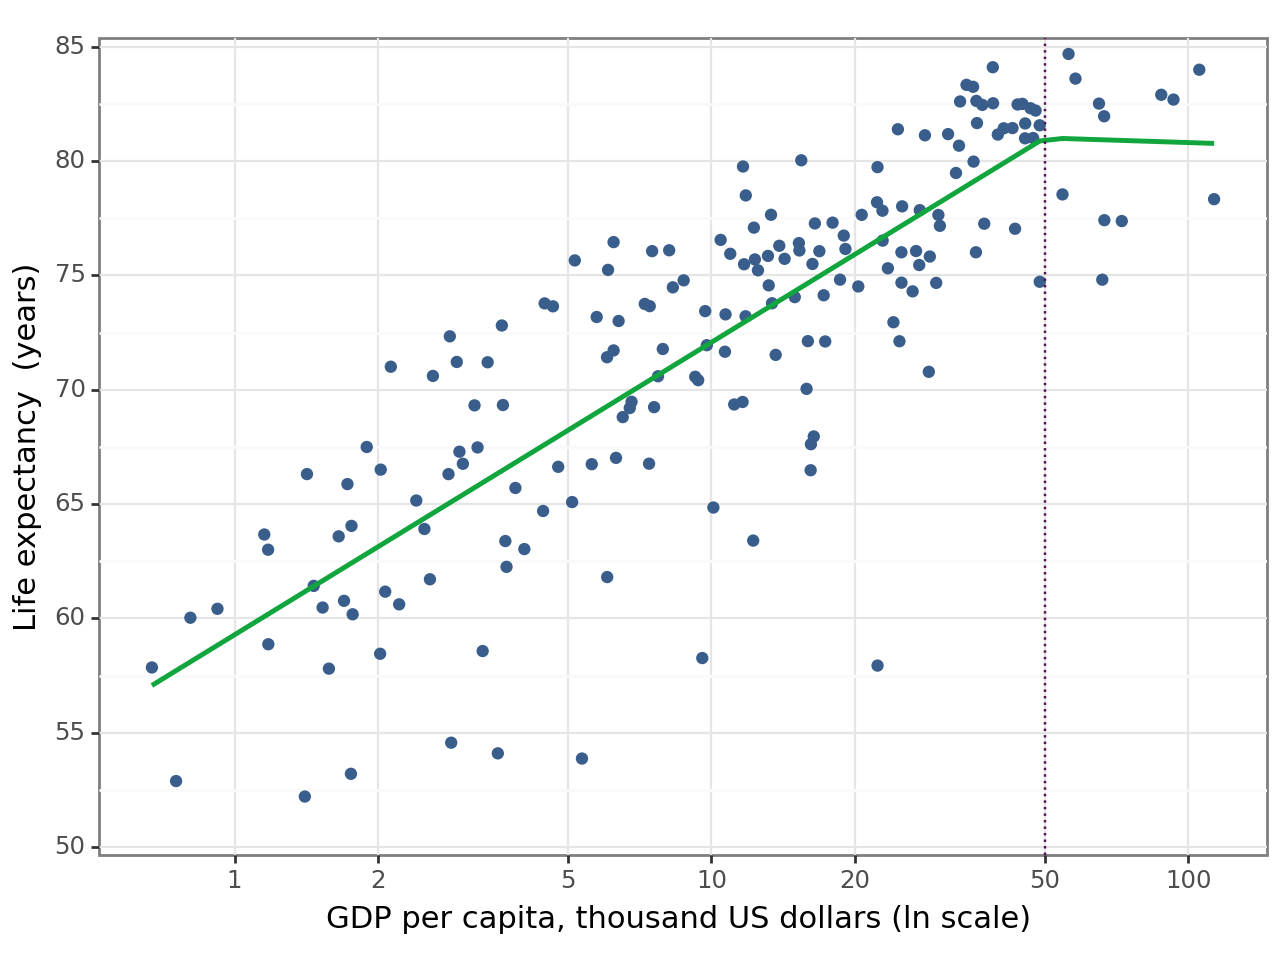

<Figure Size: (640 x 480)>

In [43]:
(
    ggplot(xc, aes(x="gdppc", y="lifeexp"))
    + geom_point(color=color[0])
    + geom_line(xc, aes(x="gdppc", y="sppred"), color=color[1], size=1) #instead of geom_smooth with lm method
    + geom_vline(xintercept=cutoff, color=color[2], size=0.5, linetype="dotted") #for the cutoff
    + coord_cartesian(ylim=(50, 85))
    #log scale
    + scale_x_continuous(
        trans=log_trans(),
        breaks=(1, 2, 5, 10, 20, 50, 100),
        labels=log_format(),
    )
    + scale_y_continuous(expand=(0.01, 0.01), breaks=seq(50, 85, by=5))
    + labs(
        x="GDP per capita, thousand US dollars (ln scale) ",
        y="Life expectancy  (years)",
    )
    + theme_bw()
)

### Quadratic transformation
$y^E =\alpha +\beta_1 x + \beta_2x^2$
-> parabola (U-shaped = convex, or concave)
- $\alpha$: average y when x is 0
- $\beta_1$: no meaningful interpretation
- $\beta_2$: signals convexity (positive) or concavity (negative) of the relation
- $\beta_1 + 2\beta_2 x$: first derivative and slope (different for different values of x)

### QUADRATIC IN LEVEL-LOG REGRESSION

In [44]:
xc["lngdppc_sq"] = xc["lngdppc"].pow(2)
reg6 = smf.ols(formula="lifeexp ~ lngdppc+lngdppc_sq", data=xc).fit()
reg6.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                lifeexp   R-squared:                       0.682
Model:                            OLS   Adj. R-squared:                  0.678
Method:                 Least Squares   F-statistic:                     192.0
Date:                Mon, 13 Nov 2023   Prob (F-statistic):           2.92e-45
Time:                        15:53:59   Log-Likelihood:                -523.75
No. Observations:                 182   AIC:                             1054.
Df Residuals:                     179   BIC:                             1063.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     58.9017      1.035     56.911      0.000      56.859      60.944
lngdppc        6.3038      0.988      6.380      0.000       4.354       8.254
lngdppc_sq    -0.2200      0.215     -1.022      0.308      -0.645       0.205
==============================================================================
Omnibus:                       43.067   Durbin-Watson:                   2.252
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               77.274
Skew:                          -1.168   Prob(JB):                     1.66e-17
Kurtosis:                       5.176   Cond. No.                         40.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

$\beta_2 <0$ -> concavity

slope = $6.3  -0.44 \times \ln(GDP_{pc})$ -> 14.3 ln GDP per capita, i.e. at  1.6 trillion dollars GDP per capita, turning point above which the implied pattern would be negative

In [45]:
xc["e6"] = reg6.resid

(b) Quadratic function

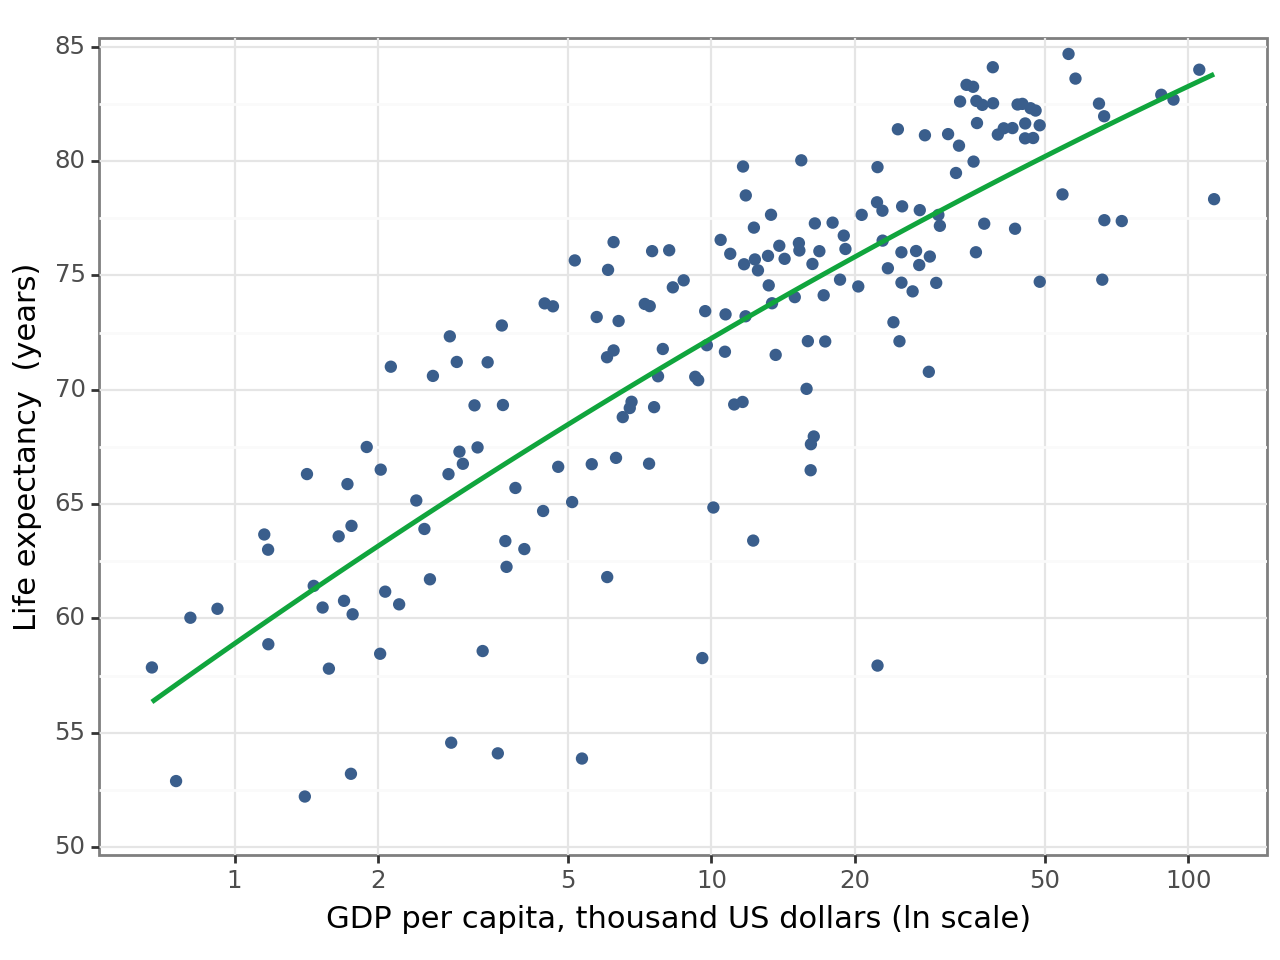

<Figure Size: (640 x 480)>

In [46]:
(
    ggplot(xc, aes(x="gdppc", y="lifeexp"))
    + geom_point(color=color[0])
    + stat_smooth(
        #add formula
        color=color[1], method="lm", formula="y ~ poly(x,2)", se=False, size=1
    )
    + coord_cartesian(ylim=(50, 85))
    + scale_x_continuous(
        trans=log_trans(),
        breaks=(1, 2, 5, 10, 20, 50, 100),
        labels=log_format(),
    )
    + scale_y_continuous(expand=(0.01, 0.01), breaks=seq(50, 85, by=5))
    + labs(
        x="GDP per capita, thousand US dollars (ln scale) ",
        y="Life expectancy  (years)",
    )
    + theme_bw()
)

### WEIGHTED AND UNWEIGHTED REGRESSION

Different observations may have different weights for two main reasons:
- compensate for unequal representation of population
- denote different size of larger units when those larger units are the observations in the data (ex pop of countries)

In our case study:
- unweighted regression compares countries
- weighted (by pop) regression compares people living in different countries 
-> people in larger countries are compared more often to other people than those in smaller countries

In [47]:
reg7 = smf.wls(formula="lifeexp ~ lngdppc", data=xc, weights=xc.population).fit()
reg7.summary()
#weight for the pop

<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:                lifeexp   R-squared:                       0.662
Model:                            WLS   Adj. R-squared:                  0.660
Method:                 Least Squares   F-statistic:                     351.9
Date:                Mon, 13 Nov 2023   Prob (F-statistic):           3.23e-44
Time:                        15:54:01   Log-Likelihood:                -659.24
No. Observations:                 182   AIC:                             1322.
Df Residuals:                     180   BIC:                             1329.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     58.7179      0.775     75.716      0.000      57.188      60.248
lngdppc        5.7529      0.307     18.760      0.000       5.148       6.358
==============================================================================
Omnibus:                      159.074   Durbin-Watson:                   2.114
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             5085.737
Skew:                          -2.901   Prob(JB):                         0.00
Kurtosis:                      28.239   Cond. No.                         7.82
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Higher slope than simple regression. People who live in countries with 10\% higher GDP per capita live, on average, 0.58 years longer (comparing people living in different countries! people in larger countries are compared more often to other people than those in smaller countries)

Estimates and R squared are similar to before because larger countries do not tilt the regression line much. (India and China are in the middle of GDP per capita distribution)

### Figure 8.9 Life expectancy and log GDP per capita: unweighted and weighted regressions

(a) Unweighted

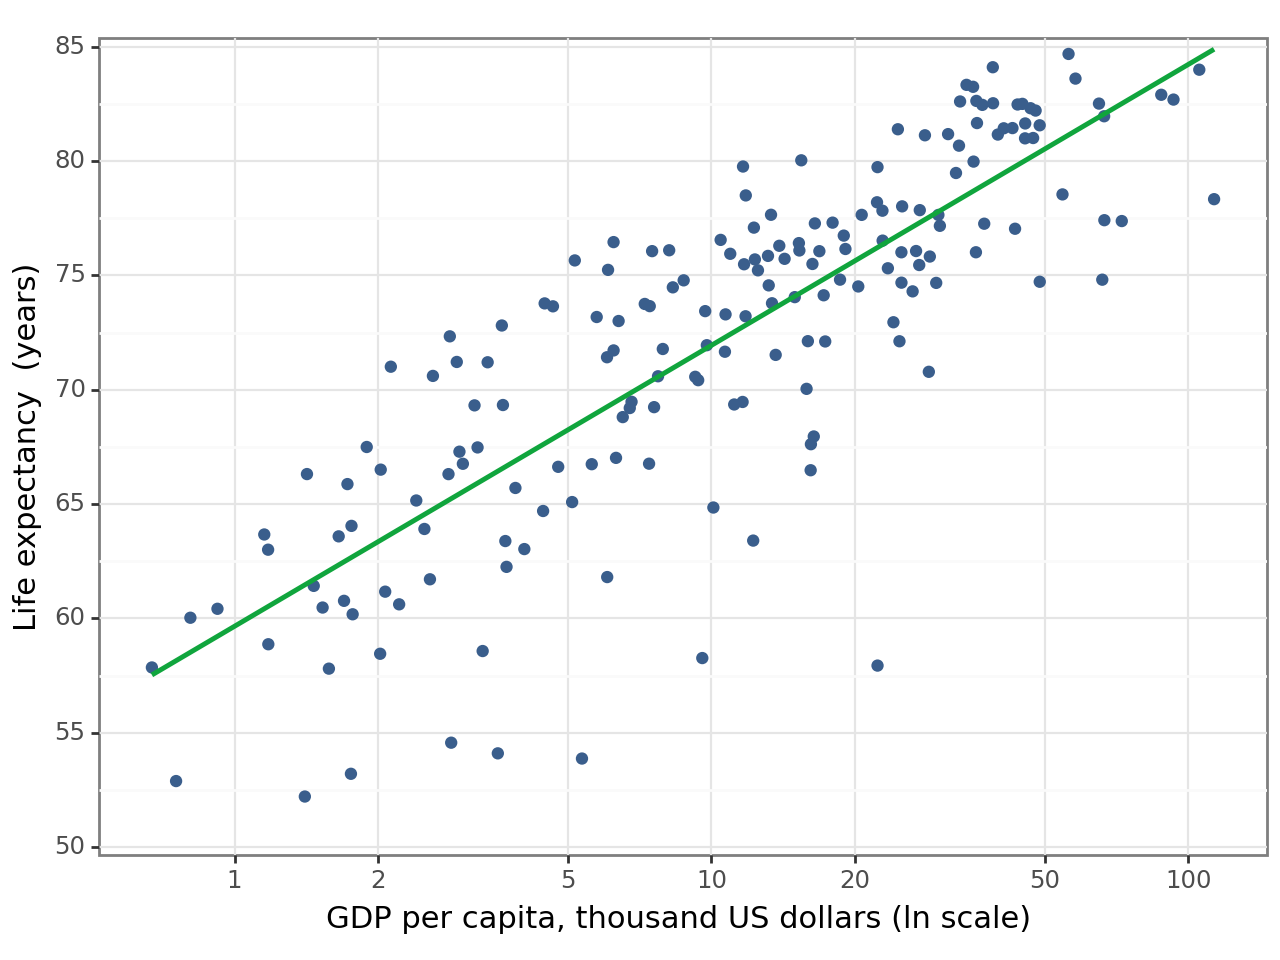

<Figure Size: (640 x 480)>

In [48]:
(
    ggplot(xc, aes(x="gdppc", y="lifeexp"))
    + geom_point(color=color[0])
    + stat_smooth(color=color[1], method="lm", se=False, size=1)
    + coord_cartesian(ylim=(50, 85))
    + scale_x_continuous(
        trans=log_trans(),
        breaks=(1, 2, 5, 10, 20, 50, 100),
        labels=log_format(),
    )
    + scale_y_continuous(expand=(0.01, 0.01), breaks=seq(50, 85, by=5))
    + labs(
        x="GDP per capita, thousand US dollars (ln scale) ",
        y="Life expectancy  (years)",
    )
    + theme_bw()
)

(b) Weighted

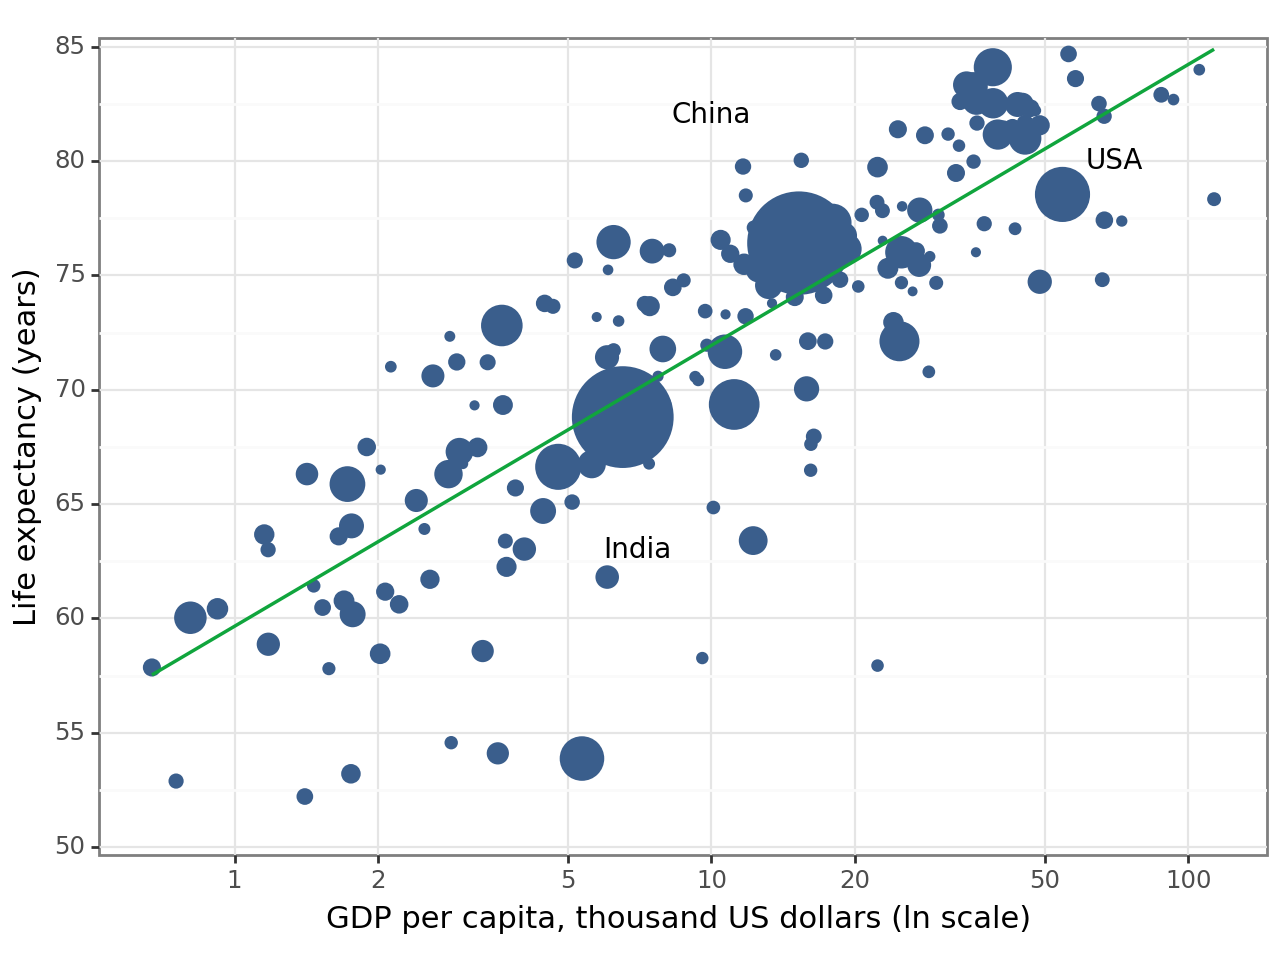

<Figure Size: (640 x 480)>

In [49]:
(
    ggplot(xc, aes(x="gdppc", y="lifeexp"))
    + geom_point( #size of points depend on population
        xc, aes(size="population"), color=color[0], alpha=0.6, show_legend=False
    )
    + scale_fill_identity()
    + scale_color_identity()
    + geom_smooth( #add the weight to the regression
        aes(weight="population"), method="lm", color=color[1], se=False, size=0.7
    )
    + scale_size(range=(1, 20))
    + coord_cartesian(ylim=(50, 85))
    + scale_x_continuous( #log scale
        trans=log_trans(),
        breaks=(1, 2, 5, 10, 20, 50, 100),
        labels=log_format(),
    )
    + scale_y_continuous(expand=(0.01, 0.01), breaks=seq(50, 85, by=5))
    + labs(
        x="GDP per capita, thousand US dollars (ln scale) ", y="Life expectancy (years)"
    )
    + theme_bw()
    + annotate("text", x=70, y=80, label="USA", size=10)
    + annotate("text", x=10, y=82, label="China", size=10)
    + annotate("text", x=7, y=63, label="India", size=10)
)

### Compare models

In [50]:
stargazer = Stargazer([reg4, reg5, reg6, reg7])
stargazer.covariate_order(["lngdppc", "lspline(lngdppc, cutoff_ln)[0]", "lspline(lngdppc, cutoff_ln)[1]", "lngdppc_sq", "Intercept"])
stargazer.rename_covariates(
    {
        "Intercept": "Constant",
        "lngdppc": "ln(GDP per capita)",
        "lngdppc_sq": "squared ln(GDP per capita)",
        "lspline(lngdppc, cutoff_ln)[0]": "first segment",
        "lspline(lngdppc, cutoff_ln)[1]": "second segment"
    }
)
stargazer

The cross-sectional relationship between life expectancy and log GDP per capita is strong positive throughout almost the entire range of observable GDP per capita.

For most of the range, a 10\% difference in GDP per capita is associated with a higher life expectancy by 1/2 of a year on average.

Life expectancy in the richest countries is lower than the average pattern would suggest (might be that the association is actually flat or there might be due to some other country-specific factors)

Are countries with unusually high and unusually low life expectancy robust across the various models? - you can check it